In [2]:
import networkx as nx
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import time
from collections import Counter
%matplotlib inline 
from tqdm import tqdm

# parameters

alpha = 0.15
a = [1, 2, 4]

def read_folder() : # ok
    all_files = sorted(os.listdir(path = "C:/Users/Chun Lok/Downloads/as-caida"))
    # print(all_files)
    return all_files

def envolving_graph(file):    
    f = open(file)
    G = nx.Graph()

    n_lines = len(f.readlines())
    # print(n_lines)
    f = open(file)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)

    for i in range(8, n_lines) :
        line = f.readline()      
        line = line[:-1]
        line = line.split("\t")
        a = int(line[0])
        b = int(line[1])
        G.add_edge(a,b)

    f.close()
    return G

def current_graph(file) :
    f = open(file)
    r = nx.Graph()

    n_lines = len(f.readlines())
    # print(n_lines)
    f = open(file)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)

    for i in range(8, n_lines):
        line = f.readline()
        line = line[:-1]
        line = line.split("\t")
        a = int(line[0])
        b = int(line[1])
        r.add_edge(a, b)
        
    f.close()
    return r

def update_graph(graph, newnode) :
    G = graph
    E = list(G.edges())

    edge = random.choice(E)
    u = edge[0]
    v = edge[1]

    # change of head
    G.remove_edge(u,v)
    u = newnode
    G.add_edge(u, v)

    return G # new graph


def Priority_probing(current_graph, priority, pagerank) :
    # priority in main function
    while True :
        if all (prior == 0 for prior in priority.values()) :
            picked_node = random.choice(list(priority.keys()))
        else :
            picked_node = max(priority, key=lambda k: priority[k])
        if(current_graph.has_node(picked_node)==True) :
            break
        else :
            priority[picked_node] = 0
            
        print(picked_node) 
    
    
    for node in list(current_graph.nodes()) :
        if node != picked_node :
            priority[node] = (priority[node] + pagerank[node]) if node in list(priority.keys()) else (0 + pagerank[node])
        else : 
            priority[node] = 0
            
        if priority[node] > 1 :
            priority[node] = 1
        
    return picked_node, priority


def PowerIteration(graph) :
    V = list(graph.nodes())
    n = len(V)
    for i in range(len(V)):
        v = V[i]
        graph.nodes[v]["old_pi"] = 1/n
        graph.nodes[v]["new_pi"] = 1/n

    # power iterations
    iterations_count = 0
    while True:
        iterations_count += 1  # (pi(1)->pi(t))
        # iterate
        for i in range(len(V)):
            v = V[i]
            graph.nodes[v]["old_pi"] = graph.nodes[v]["new_pi"]
            graph.nodes[v]["new_pi"] = 0

        for i in range(len(V)):
            v = V[i]
            temp = 0
            for u in graph.neighbors(v):
                temp += graph.nodes[u]["old_pi"] / len(list(graph.neighbors(u)))
            graph.nodes[v]["new_pi"] = (1 - alpha) * temp + alpha / n

        # check convergence
        tol = 0
        for i in range(len(V)):
            v = V[i]
            tol += np.abs(graph.nodes[v]["old_pi"] - graph.nodes[v]["new_pi"])

        if tol < 1e-9:
            # print("convergence")
            break

    # set an attribute true pagerank pi to all nodes

    pagerank = {}
    for i in range(len(V)):
        v = V[i]
        pagerank[v] = graph.nodes[v]["new_pi"]
        graph.nodes[v]["real.pi"] = graph.nodes[v]["new_pi"]

    return pagerank

def L_error(true_pi, estimated_pi) :
    # L1 = sum of (estimated_pi - true_pi) at any time step t
    # Linfinity = max error of pagerank
    
    list = []
    for key in true_pi:
        if key not in list:
            list.append(key)

    for key in estimated_pi:
        if key not in list:
            list.append(key)
     
    check= len(set(list)) == len(list)
    
    if(check) : # whether all distinct node
        print("True")
    else :
        print("false")
        
    # print(true_pi[list[1]])
    # print(estimated_pi[list[1]])
    # print(list[1])
    # print(len(list))    
    result = np.zeros(len(list))

    # print(estimated_pi(list[1]))
    # print(len(list))
    
    count = 0
    for i in range(len(list)) :
        if((list[i] in estimated_pi) and (list[i] in true_pi )) :
            result[i] = abs((estimated_pi[list[i]])-(true_pi[list[i]]))          
        elif ((list[i] in estimated_pi) and (list[i] not in true_pi)) :
            result[i] = estimated_pi[list[i]]            
        else :
            result[i] = true_pi[list[i]] 
        count+=result[i]
        
    # print(count)
    # print(max(result))
    return count , max(result)


In [3]:
list_of_file = read_folder()

for i in range(len(list_of_file)) :
    list_of_file[i] = "C:/Users/Chun Lok/Downloads/as-caida/" + list_of_file[i]  
    
# print(len(list_of_file))

G = envolving_graph(list_of_file[0])
# print(len(list(G.edges())))

K = 1 # recomputing frequency 
changes = []
L1_metric = []
Linfinity_metric = []

priority = dict.fromkeys(list(G.nodes()),0)

for i in tqdm(range(1,len(list_of_file)),desc="Loading…", ascii=False, ncols=75) :
    g = current_graph(list_of_file[i])
    true_pi = PowerIteration(g) 
#______________________________________________________________________# 
    node , priority = Priority_probing(g, priority, true_pi)
    G = update_graph(G, node) 
    changes.append(i)

    estimated_pi = PowerIteration(G)
    
    L1_error, Linfinity_error = L_error(true_pi, estimated_pi)
    L1_metric.append(L1_error)
    Linfinity_metric.append(Linfinity_error)

    
print("Complete")

Loading…:   1%|▏                         | 1/121 [00:51<1:42:32, 51.27s/it]

True


Loading…:   2%|▍                         | 2/121 [01:42<1:41:33, 51.20s/it]

True


Loading…:   2%|▋                         | 3/121 [02:49<1:54:55, 58.44s/it]

True


Loading…:   3%|▊                         | 4/121 [03:53<1:58:16, 60.65s/it]

True


Loading…:   4%|█                         | 5/121 [04:55<1:57:59, 61.03s/it]

True


Loading…:   5%|█▎                        | 6/121 [05:58<1:58:30, 61.83s/it]

True


Loading…:   6%|█▌                        | 7/121 [07:01<1:57:54, 62.05s/it]

True


Loading…:   7%|█▋                        | 8/121 [08:11<2:01:48, 64.67s/it]

True


Loading…:   7%|█▉                        | 9/121 [09:17<2:01:22, 65.02s/it]

True


Loading…:   8%|██                       | 10/121 [10:25<2:02:22, 66.15s/it]

True


Loading…:   9%|██▎                      | 11/121 [11:35<2:03:13, 67.21s/it]

True


Loading…:  10%|██▍                      | 12/121 [12:46<2:04:02, 68.28s/it]

True


Loading…:  11%|██▋                      | 13/121 [13:56<2:04:01, 68.90s/it]

True


Loading…:  12%|██▉                      | 14/121 [15:01<2:00:56, 67.82s/it]

True


Loading…:  12%|███                      | 15/121 [16:11<2:00:33, 68.24s/it]

True


Loading…:  13%|███▎                     | 16/121 [17:19<1:59:34, 68.33s/it]

True


Loading…:  14%|███▌                     | 17/121 [18:29<1:59:27, 68.92s/it]

True


Loading…:  15%|███▋                     | 18/121 [19:42<2:00:04, 69.95s/it]

True


Loading…:  16%|███▉                     | 19/121 [20:54<1:59:56, 70.56s/it]

True


Loading…:  17%|████▏                    | 20/121 [22:05<1:58:57, 70.67s/it]

True


Loading…:  17%|████▎                    | 21/121 [23:17<1:58:25, 71.05s/it]

True


Loading…:  18%|████▌                    | 22/121 [24:32<1:59:24, 72.37s/it]

True


Loading…:  19%|████▊                    | 23/121 [25:47<1:59:27, 73.14s/it]

True


Loading…:  20%|████▉                    | 24/121 [27:03<1:59:36, 73.99s/it]

True


Loading…:  21%|█████▏                   | 25/121 [28:21<2:00:08, 75.09s/it]

True


Loading…:  21%|█████▎                   | 26/121 [29:37<1:59:38, 75.57s/it]

True


Loading…:  22%|█████▌                   | 27/121 [30:53<1:58:21, 75.55s/it]

True


Loading…:  23%|█████▊                   | 28/121 [32:11<1:58:28, 76.44s/it]

True


Loading…:  24%|█████▉                   | 29/121 [33:33<1:59:32, 77.96s/it]

True


Loading…:  25%|██████▏                  | 30/121 [34:57<2:01:02, 79.81s/it]

True


Loading…:  26%|██████▍                  | 31/121 [36:36<2:08:36, 85.74s/it]

True


Loading…:  26%|██████▌                  | 32/121 [38:20<2:15:14, 91.18s/it]

True


Loading…:  27%|██████▊                  | 33/121 [40:13<2:23:15, 97.68s/it]

True


Loading…:  28%|███████                  | 34/121 [41:41<2:17:09, 94.59s/it]

True


Loading…:  29%|███████▏                 | 35/121 [42:57<2:07:49, 89.18s/it]

True


Loading…:  30%|███████▍                 | 36/121 [44:13<2:00:32, 85.09s/it]

True


Loading…:  31%|███████▋                 | 37/121 [45:33<1:57:04, 83.63s/it]

True


Loading…:  31%|███████▊                 | 38/121 [46:53<1:54:01, 82.43s/it]

True


Loading…:  32%|████████                 | 39/121 [48:15<1:52:32, 82.35s/it]

True


Loading…:  33%|████████▎                | 40/121 [49:41<1:52:48, 83.57s/it]

True


Loading…:  34%|████████▍                | 41/121 [51:07<1:52:16, 84.21s/it]

True


Loading…:  35%|████████▋                | 42/121 [52:23<1:47:37, 81.74s/it]

True


Loading…:  36%|████████▉                | 43/121 [53:47<1:47:21, 82.59s/it]

True


Loading…:  36%|█████████                | 44/121 [55:05<1:44:07, 81.14s/it]

True


Loading…:  37%|█████████▎               | 45/121 [56:29<1:43:52, 82.00s/it]

True


Loading…:  38%|█████████▌               | 46/121 [57:53<1:43:16, 82.62s/it]

True


Loading…:  39%|█████████▋               | 47/121 [59:12<1:40:20, 81.36s/it]

True


Loading…:  40%|█████████              | 48/121 [1:00:51<1:45:38, 86.83s/it]

True


Loading…:  40%|█████████▎             | 49/121 [1:02:13<1:42:12, 85.17s/it]

True


Loading…:  41%|█████████▌             | 50/121 [1:03:30<1:38:09, 82.95s/it]

True


Loading…:  42%|█████████▋             | 51/121 [1:04:50<1:35:44, 82.07s/it]

True


Loading…:  43%|█████████▉             | 52/121 [1:06:15<1:35:25, 82.97s/it]

True


Loading…:  44%|██████████             | 53/121 [1:07:37<1:33:29, 82.50s/it]

True


Loading…:  45%|██████████▎            | 54/121 [1:08:59<1:32:00, 82.40s/it]

True


Loading…:  45%|██████████▍            | 55/121 [1:10:20<1:30:02, 81.86s/it]

True


Loading…:  46%|██████████▋            | 56/121 [1:11:40<1:28:15, 81.47s/it]

True


Loading…:  47%|██████████▊            | 57/121 [1:13:08<1:29:04, 83.50s/it]

True


Loading…:  48%|███████████            | 58/121 [1:14:46<1:32:02, 87.65s/it]

True


Loading…:  49%|███████████▏           | 59/121 [1:16:23<1:33:32, 90.52s/it]

True


Loading…:  50%|███████████▍           | 60/121 [1:17:52<1:31:31, 90.03s/it]

True


Loading…:  50%|███████████▌           | 61/121 [1:19:18<1:28:44, 88.75s/it]

True


Loading…:  51%|███████████▊           | 62/121 [1:20:45<1:27:02, 88.52s/it]

True


Loading…:  52%|███████████▉           | 63/121 [1:22:13<1:25:17, 88.23s/it]

True


Loading…:  53%|████████████▏          | 64/121 [1:23:47<1:25:30, 90.01s/it]

True


Loading…:  54%|████████████▎          | 65/121 [1:25:37<1:29:29, 95.89s/it]

True


Loading…:  55%|████████████▌          | 66/121 [1:27:05<1:25:48, 93.60s/it]

True


Loading…:  55%|████████████▋          | 67/121 [1:28:34<1:22:54, 92.13s/it]

True


Loading…:  56%|████████████▉          | 68/121 [1:30:03<1:20:44, 91.40s/it]

True


Loading…:  57%|█████████████          | 69/121 [1:31:35<1:19:08, 91.32s/it]

True


Loading…:  58%|█████████████▎         | 70/121 [1:33:08<1:18:13, 92.02s/it]

True


Loading…:  59%|█████████████▍         | 71/121 [1:34:47<1:18:23, 94.06s/it]

True


Loading…:  60%|█████████████▋         | 72/121 [1:36:27<1:18:15, 95.82s/it]

True


Loading…:  60%|█████████████▉         | 73/121 [1:37:58<1:15:30, 94.39s/it]

True


Loading…:  61%|██████████████         | 74/121 [1:39:29<1:13:11, 93.43s/it]

True


Loading…:  62%|██████████████▎        | 75/121 [1:41:04<1:12:01, 93.95s/it]

True


Loading…:  63%|██████████████▍        | 76/121 [1:42:34<1:09:30, 92.67s/it]

True


Loading…:  64%|██████████████▋        | 77/121 [1:44:09<1:08:21, 93.21s/it]

True


Loading…:  64%|██████████████▊        | 78/121 [1:45:41<1:06:41, 93.05s/it]

True


Loading…:  65%|███████████████        | 79/121 [1:47:15<1:05:16, 93.24s/it]

True


Loading…:  66%|███████████████▏       | 80/121 [1:48:42<1:02:22, 91.28s/it]

True


Loading…:  67%|███████████████▍       | 81/121 [1:50:16<1:01:23, 92.09s/it]

True


Loading…:  68%|███████████████▌       | 82/121 [1:51:57<1:01:34, 94.74s/it]

True


Loading…:  69%|███████████████▊       | 83/121 [1:53:35<1:00:46, 95.97s/it]

True


Loading…:  69%|█████████████████▎       | 84/121 [1:55:09<58:43, 95.24s/it]

True


Loading…:  70%|█████████████████▌       | 85/121 [1:56:45<57:16, 95.47s/it]

True


Loading…:  71%|█████████████████▊       | 86/121 [1:58:27<56:47, 97.35s/it]

True


Loading…:  72%|█████████████████▉       | 87/121 [2:00:02<54:44, 96.61s/it]

True


Loading…:  73%|██████████████████▏      | 88/121 [2:01:38<53:11, 96.70s/it]

True


Loading…:  74%|██████████████████▍      | 89/121 [2:03:17<51:53, 97.30s/it]

True


Loading…:  74%|██████████████████▌      | 90/121 [2:04:56<50:33, 97.86s/it]

True


Loading…:  75%|██████████████████▊      | 91/121 [2:06:33<48:42, 97.42s/it]

True


Loading…:  76%|███████████████████      | 92/121 [2:08:09<46:51, 96.94s/it]

True


Loading…:  77%|███████████████████▏     | 93/121 [2:09:50<45:52, 98.32s/it]

True


Loading…:  78%|███████████████████▍     | 94/121 [2:11:30<44:30, 98.91s/it]

True


Loading…:  79%|██████████████████▊     | 95/121 [2:13:13<43:20, 100.03s/it]

True


Loading…:  79%|███████████████████▊     | 96/121 [2:14:50<41:16, 99.07s/it]

True


Loading…:  80%|████████████████████     | 97/121 [2:16:30<39:43, 99.32s/it]

True


Loading…:  81%|████████████████████▏    | 98/121 [2:18:09<38:05, 99.37s/it]

True


Loading…:  82%|████████████████████▍    | 99/121 [2:19:48<36:19, 99.07s/it]

True


Loading…:  83%|███████████████████    | 100/121 [2:21:34<35:29, 101.40s/it]

True


Loading…:  83%|███████████████████▏   | 101/121 [2:23:20<34:12, 102.65s/it]

True


Loading…:  84%|███████████████████▍   | 102/121 [2:25:09<33:05, 104.49s/it]

True


Loading…:  85%|███████████████████▌   | 103/121 [2:27:07<32:35, 108.63s/it]

True


Loading…:  86%|███████████████████▊   | 104/121 [2:28:55<30:42, 108.40s/it]

True


Loading…:  87%|███████████████████▉   | 105/121 [2:30:44<28:58, 108.64s/it]

True


Loading…:  88%|████████████████████▏  | 106/121 [2:32:35<27:18, 109.23s/it]

True


Loading…:  88%|████████████████████▎  | 107/121 [2:34:22<25:20, 108.58s/it]

True


Loading…:  89%|████████████████████▌  | 108/121 [2:36:11<23:31, 108.61s/it]

True


Loading…:  90%|████████████████████▋  | 109/121 [2:37:59<21:41, 108.45s/it]

True


Loading…:  91%|████████████████████▉  | 110/121 [2:39:44<19:41, 107.45s/it]

True


Loading…:  92%|█████████████████████  | 111/121 [2:41:30<17:52, 107.21s/it]

True


Loading…:  93%|█████████████████████▎ | 112/121 [2:43:25<16:24, 109.39s/it]

True


Loading…:  93%|██████████████████████▍ | 113/121 [2:44:11<12:03, 90.47s/it]

True


Loading…:  94%|██████████████████████▌ | 114/121 [2:46:00<11:11, 95.96s/it]

True


Loading…:  95%|██████████████████████▊ | 115/121 [2:47:44<09:50, 98.39s/it]

True


Loading…:  96%|██████████████████████ | 116/121 [2:49:29<08:21, 100.33s/it]

True


Loading…:  97%|██████████████████████▏| 117/121 [2:51:17<06:50, 102.66s/it]

True


Loading…:  98%|██████████████████████▍| 118/121 [2:53:03<05:11, 103.69s/it]

True


Loading…:  98%|██████████████████████▌| 119/121 [2:54:54<03:31, 105.80s/it]

True


Loading…:  99%|██████████████████████▊| 120/121 [2:56:44<01:47, 107.02s/it]

True


Loading…: 100%|████████████████████████| 121/121 [2:58:33<00:00, 88.54s/it]

True
Complete


In [6]:
def L1_error_graph(L1_metric) :
        
    ch = [1]
    for i in range(2,122):
        ch.append(ch[i-2]+i)
         
    # print(ch)
    plt.plot(ch ,L1_metric)
    plt.ylabel('averageL1_error')
    plt.xlabel('# changes')
    plt.show()
    

def Linfinity_error_graph(Linfinity_metric) :
    
    ch = [1]
    for i in range(2,122):
        ch.append(ch[i-2]+i)
        
    plt.plot(ch,Linfinity_metric)
    plt.ylabel('averageLinfinity_error')
    plt.xlabel('# changes')
    plt.title
    plt.show()

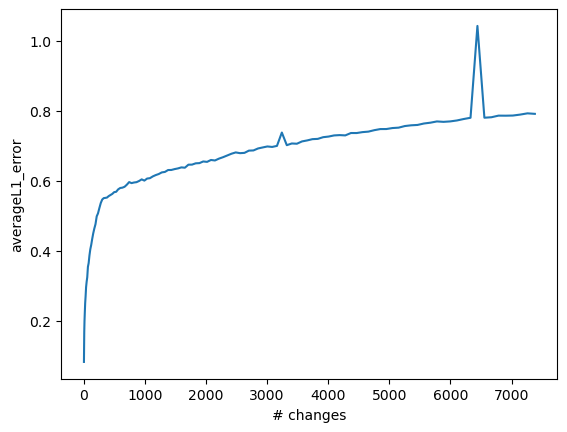

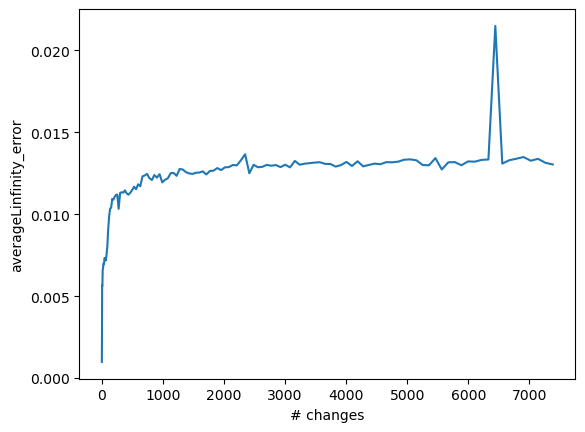

In [7]:
L1_error_graph(L1_metric)
Linfinity_error_graph(Linfinity_metric)